波段数量: 2
图像尺寸: 5518 x 4007
投影信息: EPSG:4326


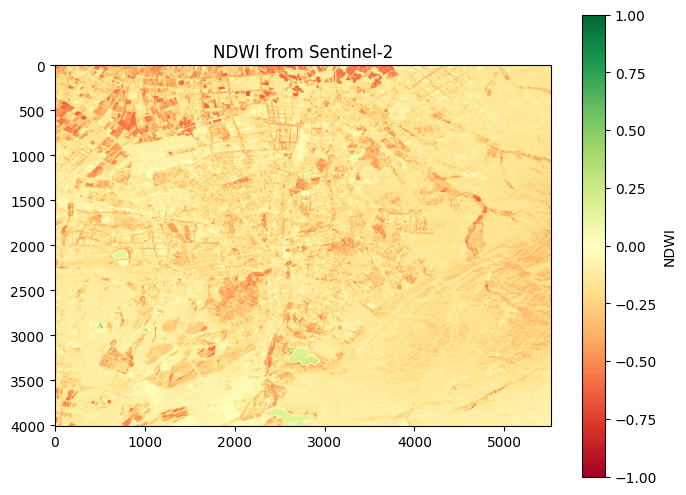

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 假设你的多波段 tif 文件叫 Urumqi_B03_B08.tif
tif_file = "Urumqi_B03_B08.tif"

with rasterio.open(tif_file) as src:
    print("波段数量:", src.count)
    print("图像尺寸:", src.width, "x", src.height)
    print("投影信息:", src.crs)

    # Sentinel-2: B3 (Green), B8 (NIR)
    # 注意：不同文件来源波段顺序可能不同，这里假设B3是第1个波段，B8是第2个
    green = src.read(1).astype('float32')  # 读取B3
    nir = src.read(2).astype('float32')    # 读取B8

# 避免除零错误
leak_mask = (green - nir) / (green + nir + 1e-10)

# 可视化 NDWI
plt.figure(figsize=(8,6))
plt.imshow(leak_mask, cmap='RdYlGn')
plt.colorbar(label="NDWI")
plt.title("NDWI from Sentinel-2")
plt.show()


C:\Users\pluto\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pluto\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pluto\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28431 (\N{CJK UNIFIED IDEOGRAPH-6F0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pluto\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pluto\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 213

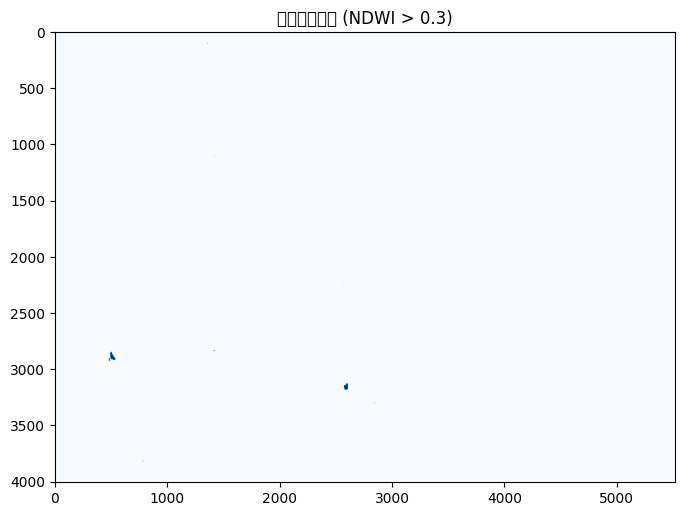

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 ndwi 是之前计算好的 NDWI 数组
leak_mask = ndwi > 0.3  # NDWI 高于阈值的地方可能漏水

# 可视化
plt.figure(figsize=(8,6))
plt.imshow(leak_mask, cmap='Blues')  # True 显示为蓝色
plt.title("可能漏水区域 (NDWI > 0.3)")
plt.show()


In [10]:
import rasterio

tif_path = "../data/S1_June20.tif"

with rasterio.open(tif_path) as src:
    print("波段数:", src.count)  # src.count 表示波段数
    print("宽度，高度:", src.width, src.height)

波段数: 2
宽度，高度: 221 161


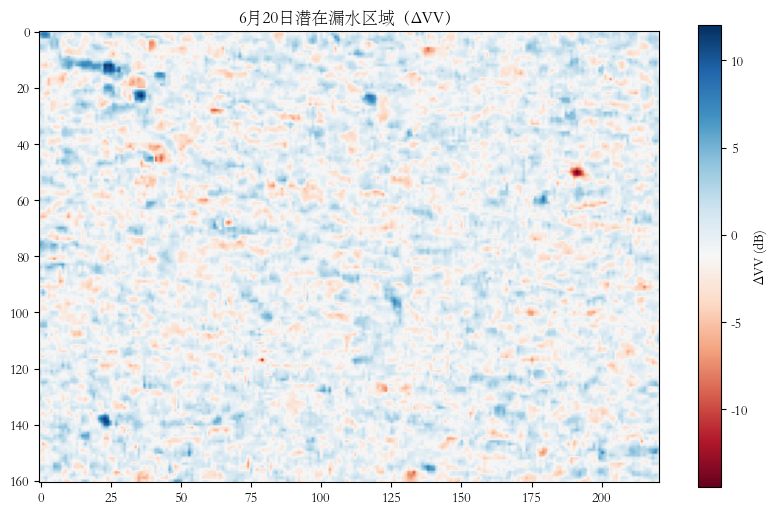

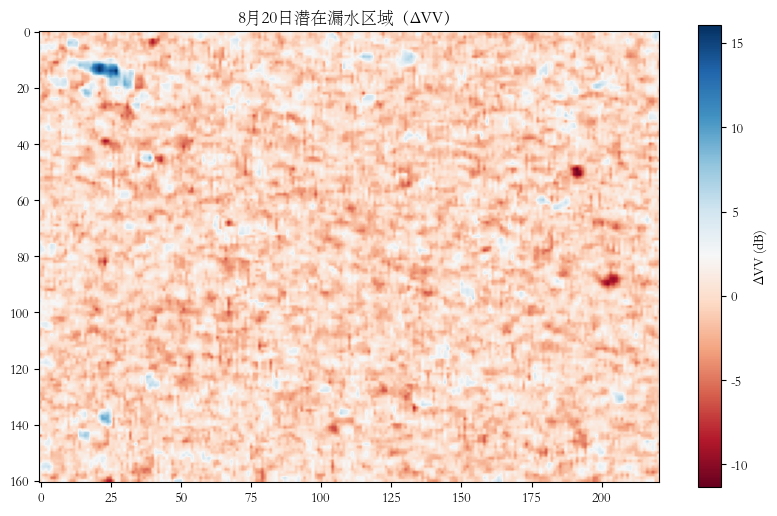

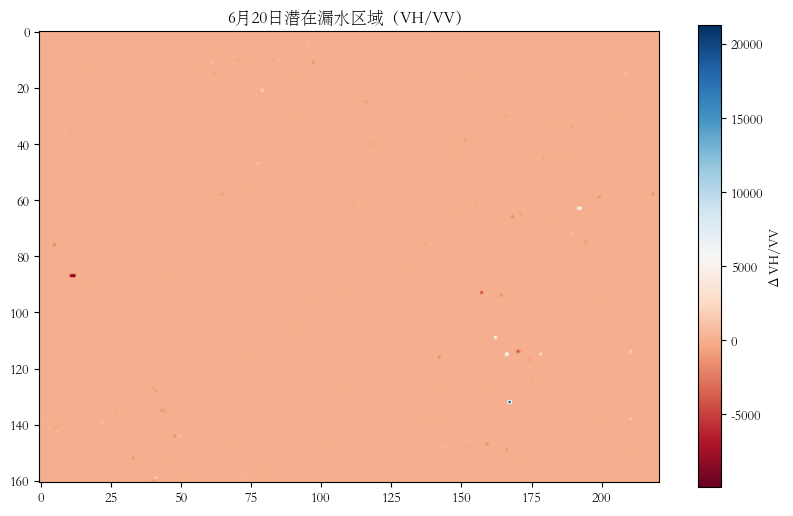

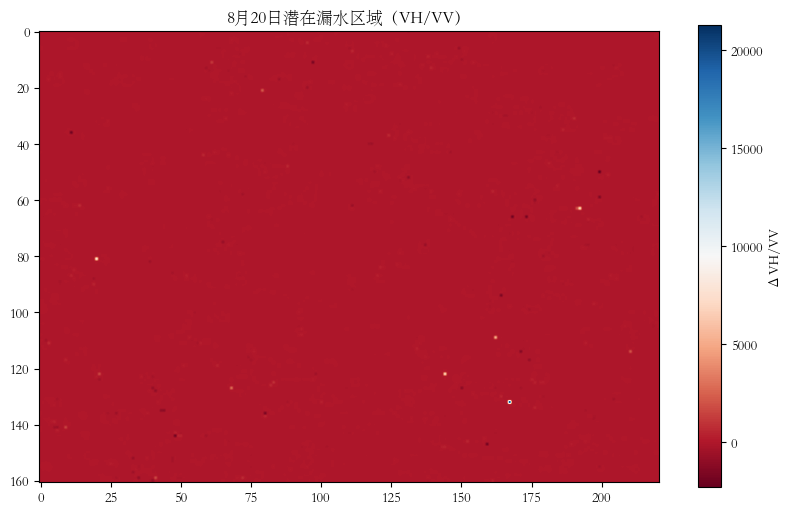

导出完成: leak_june20.geojson
导出完成: leak_aug20.geojson


In [17]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape


# ----------------------------
# 1️⃣ 配置文件路径
# ----------------------------
tif_june = "../data/S1_June20.tif"     # 6月20日
tif_aug = "../data/S1_Aug20.tif"       # 8月20日
tif_dry = "../data/S1_DrySeason.tif"   # 干燥期

# ----------------------------
# 2️⃣ 读取波段函数
# ----------------------------
def read_vv_vh(tif_path):
    with rasterio.open(tif_path) as src:
        count = src.count
        if count >= 2:
            vv = src.read(1)
            vh = src.read(2)
        else:
            vv = src.read(1)
            vh = None
        profile = src.profile
    return vv, vh, profile

vv_june, vh_june, profile = read_vv_vh(tif_june)
vv_aug, vh_aug, _ = read_vv_vh(tif_aug)
vv_dry, vh_dry, _ = read_vv_vh(tif_dry)

# ----------------------------
# 3️⃣ 计算异常指标
# ----------------------------
# ΔVV: 当前日期 vs 干燥期
delta_vv_june = vv_june - vv_dry
delta_vv_aug = vv_aug - vv_dry

# VH/VV 湿度指数
def wetness_index(vv, vh):
    if vh is None:
        return None
    return np.divide(vh, vv, out=np.zeros_like(vv), where=vv!=0)

wetness_june = wetness_index(vv_june, vh_june)
wetness_aug  = wetness_index(vv_aug, vh_aug)
wetness_delta_june = wetness_june - wetness_index(vv_dry, vh_dry)
wetness_delta_aug  = wetness_aug - wetness_index(vv_dry, vh_dry)

# ----------------------------
# 4️⃣ 可视化 ΔVV
# ----------------------------
plt.rcParams['font.sans-serif'] = ['STSong']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,6))
plt.imshow(delta_vv_june, cmap='RdBu')
plt.colorbar(label='ΔVV (dB)')
plt.title('6月20日潜在漏水区域（ΔVV）')
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(delta_vv_aug, cmap='RdBu')
plt.colorbar(label='ΔVV (dB)')
plt.title('8月20日潜在漏水区域（ΔVV）')
plt.show()

# ----------------------------
# 5️⃣ 可视化 VH/VV 湿度指数差
# ----------------------------
if wetness_delta_june is not None:
    plt.figure(figsize=(10,6))
    plt.imshow(wetness_delta_june, cmap='RdBu')
    plt.colorbar(label='Δ VH/VV')
    plt.title('6月20日潜在漏水区域（VH/VV）')
    plt.show()

if wetness_delta_aug is not None:
    plt.figure(figsize=(10,6))
    plt.imshow(wetness_delta_aug, cmap='RdBu')
    plt.colorbar(label='Δ VH/VV')
    plt.title('8月20日潜在漏水区域（VH/VV）')
    plt.show()

# ----------------------------
# 6️⃣ 标记异常区域并导出为 GeoJSON
# ----------------------------
def export_leak_mask(delta_array, profile, threshold, out_file):
    mask = delta_array > threshold
    # 转换为矢量
    shapes_gen = shapes(mask.astype(np.uint8), mask=mask, transform=profile['transform'])
    geoms = [shape(geom) for geom, val in shapes_gen if val == 1]
    gdf = gpd.GeoDataFrame(geometry=geoms, crs=profile['crs'])
    gdf.to_file(out_file, driver='GeoJSON')
    print(f"导出完成: {out_file}")

# 设置阈值，例如 ΔVV > 2 dB
export_leak_mask(delta_vv_june, profile, threshold=2, out_file="leak_june20.geojson")
export_leak_mask(delta_vv_aug, profile, threshold=2, out_file="leak_aug20.geojson")


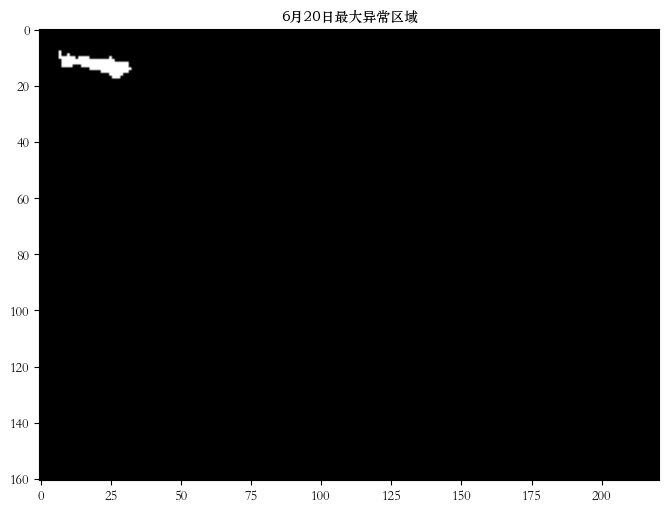

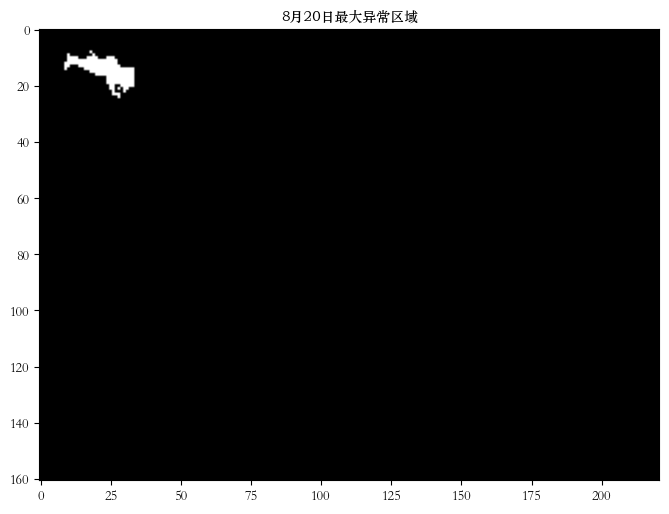

导出完成: leak_june20_max.geojson
导出完成: leak_aug20_max.geojson


In [19]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
from skimage import measure

# ----------------------------
# 1️⃣ 设置中文字体
# ----------------------------
# 使用本地 ttf 字体文件
font_path = "C:/Windows/Fonts/STZHONGS.TTF"  # 修改为你本地字体路径
my_font = font_manager.FontProperties(fname=font_path)

# ----------------------------
# 2️⃣ 配置文件路径
# ----------------------------
tif_june = "../data/S1_June20.tif"     # 6月20日
tif_aug = "../data/S1_Aug20.tif"       # 8月20日
tif_dry = "../data/S1_DrySeason.tif"   # 干燥期

# ----------------------------
# 3️⃣ 读取 VV/VH 波段函数
# ----------------------------
def read_vv_vh(tif_path):
    with rasterio.open(tif_path) as src:
        if src.count >= 2:
            vv = src.read(1)
            vh = src.read(2)
        else:
            vv = src.read(1)
            vh = None
        profile = src.profile
    return vv, vh, profile

vv_june, vh_june, profile = read_vv_vh(tif_june)
vv_aug, vh_aug, _ = read_vv_vh(tif_aug)
vv_dry, vh_dry, _ = read_vv_vh(tif_dry)

# ----------------------------
# 4️⃣ 计算异常指标
# ----------------------------
delta_vv_june = vv_june - vv_dry
delta_vv_aug = vv_aug - vv_dry

def wetness_index(vv, vh):
    if vh is None:
        return None
    return np.divide(vh, vv, out=np.zeros_like(vv), where=vv!=0)

wetness_delta_june = wetness_index(vv_june, vh_june) - wetness_index(vv_dry, vh_dry) if vh_june is not None else None
wetness_delta_aug  = wetness_index(vv_aug, vh_aug) - wetness_index(vv_dry, vh_dry) if vh_aug is not None else None

# ----------------------------
# 5️⃣ 自动筛选最大异常区域
# ----------------------------
def extract_largest_region(delta_array, threshold):
    mask = delta_array > threshold
    labeled_mask = measure.label(mask)  # 连通区域标记
    regions = measure.regionprops(labeled_mask)
    if not regions:
        return np.zeros_like(delta_array, dtype=np.uint8)
    # 找到最大面积区域
    largest_region = max(regions, key=lambda r: r.area)
    largest_mask = (labeled_mask == largest_region.label).astype(np.uint8)
    return largest_mask

threshold = 2  # ΔVV 或 Δ VH/VV 阈值
leak_mask_june = extract_largest_region(delta_vv_june, threshold)
leak_mask_aug = extract_largest_region(delta_vv_aug, threshold)

# ----------------------------
# 6️⃣ 可视化最大异常区域
# ----------------------------
plt.figure(figsize=(8,6))
plt.imshow(leak_mask_june, cmap='gray')
plt.title('6月20日最大异常区域', fontproperties=my_font)
plt.show()

plt.figure(figsize=(8,6))
plt.imshow(leak_mask_aug, cmap='gray')
plt.title('8月20日最大异常区域', fontproperties=my_font)
plt.show()

# ----------------------------
# 7️⃣ 导出为 GeoJSON
# ----------------------------
def export_geojson(mask, profile, out_file):
    shapes_gen = shapes(mask, mask=mask.astype(bool), transform=profile['transform'])
    geoms = [shape(geom) for geom, val in shapes_gen if val == 1]
    gdf = gpd.GeoDataFrame(geometry=geoms, crs=profile['crs'])
    gdf.to_file(out_file, driver='GeoJSON', encoding='utf-8')
    print(f"导出完成: {out_file}")

export_geojson(leak_mask_june, profile, "leak_june20_max.geojson")
export_geojson(leak_mask_aug, profile, "leak_aug20_max.geojson")
